In [1]:

import os
import json
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForCausalLM,
    GenerationConfig,
)
import torch
import torch.nn.functional as F
from fancy_einsum import einsum
import einops

from verl.utils.dataset.rl_dataset import RLHFDataset
from record_utils import record_activations, get_module
from parse_utils import get_target_indices
from HookedQwen import convert_to_hooked_model

In [2]:


def seed_all(seed, deterministic_algos=False):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    if deterministic_algos:
        torch.use_deterministic_algorithms()


def collate_fn(data_list: list[dict]) -> dict:
    tensors = {}
    non_tensors = {}

    for data in data_list:
        for key, val in data.items():
            if isinstance(val, torch.Tensor):
                if key not in tensors:
                    tensors[key] = []
                tensors[key].append(val)
            else:
                if key not in non_tensors:
                    non_tensors[key] = []
                non_tensors[key].append(val)

    for key, val in tensors.items():
        tensors[key] = torch.stack(val, dim=0)

    for key, val in non_tensors.items():
        non_tensors[key] = np.array(val, dtype=object)

    output = {}
    output.update(tensors)
    output.update(non_tensors)
    return output


def get_dataloader(config, tokenizer):
    import pandas as pd
    from datasets import Dataset
    from torch.utils.data import DataLoader

    data_path = config["data_path"]
    batch_size = config["batch_size"]
    max_prompt_length = config["max_prompt_length"]
    valid_size = config["valid_size"]
    data = pd.read_parquet(data_path)
    # dataset = Dataset.from_pandas(data)
    dataset = RLHFDataset(
        data_path,
        tokenizer,
        prompt_key="prompt",
        max_prompt_length=max_prompt_length,
        filter_prompts=True,
        cache_dir="~/.cache/verl/rlhf",
        chat_template_func=None,
        return_raw_chat=False,
        truncation="error",
    )

    train_dataset, valid_dataset = torch.utils.data.random_split(
        dataset, [len(dataset) - valid_size, valid_size]
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
        collate_fn=collate_fn,
    )
    return train_loader, valid_loader


def unembed(vector, lm_head, k=10):
    dots = einsum("vocab d_model, d_model -> vocab", lm_head, vector)
    top_k = dots.topk(k).indices
    return top_k


def unembed_text(vector, lm_head, tokenizer, k=10):
    top_k = unembed(vector, lm_head, k=k)
    return tokenizer.batch_decode(top_k, skip_special_tokens=True)

In [3]:

config = {
    "data_path": "data/train.parquet",
    "model_path": "checkpoints/TinyZero/v4/actor/global_step_300",
    "probe_path": "probe_checkpoints/v2/probe.pt",
    "batch_size": 4,
    "valid_size": 256,
    "max_prompt_length": 256,
    "max_response_length": 300,
    "n_layers": 36,
    "d_model": 2048,
    "seed": 42,
    "hook_config": {
        "hook_layers": list(range(24, 33)),
        "hook_target_char": " (",
        "hook_target_threshold": 0,
        "hook_scale": 20,
    },
}

In [4]:

seed_all(config["seed"])

In [5]:


model_path = config["model_path"]
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
actor_model_config = AutoConfig.from_pretrained(model_path, trust_remote_code=True)
with torch.device("cuda"):
    actor_model = AutoModelForCausalLM.from_pretrained(
        model_path, attn_implementation="eager"
    )

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:

convert_to_hooked_model(actor_model)

In [7]:

train_dataloader, valid_dataloader = get_dataloader(config, tokenizer)

original dataset len: 327680
filter dataset len: 327680


In [8]:

generation_config = GenerationConfig(do_sample=False)
actor_model.cuda()

# [vocab, d_model]
lm_head = actor_model.lm_head.weight

max_new_tokens = config["max_response_length"]
max_prompt_length = config["max_prompt_length"]
n_layers = config["n_layers"]
d_model = config["d_model"]
block_size = actor_model.config.max_position_embeddings
hook_config = config["hook_config"]

In [9]:

actor_model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 2048, padding_idx=151643)
    (layers): ModuleList(
      (0-35): 36 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=256, bias=True)
          (v_proj): Linear(in_features=2048, out_features=256, bias=True)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (hook_attn_pattern): HookPoint()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (up_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
      )
    )

In [10]:

record_module_names = [
    "model.layers.0.self_attn.q_proj",
    "model.layers.0.self_attn.k_proj",
    "model.layers.0.self_attn.v_proj",
    "model.layers.0.self_attn.o_proj",
    "model.layers.0.self_attn.hook_attn_pattern",
]

for batch_idx, batch in enumerate(valid_dataloader):

    input_ids = batch["input_ids"].cuda()
    attention_mask = batch["attention_mask"].cuda()

    with record_activations(actor_model, record_module_names) as recording:
        output = actor_model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            generation_config=generation_config,
            output_scores=False,  # this is potentially very large
            return_dict_in_generate=True,
            use_cache=True,
        )

    # len(recording["model.layers.0"]): max_response_length
    # recording["model.layers.0"][0].shape: [batch, prompt_length, d_model]
    # recording["model.layers.0"][1].shape: [batch, 1, d_model]
    # recording = {
    #    layer_name: torch.cat(acts, dim=1) for layer_name, acts in recording.items()
    # }

    # recording["model.layers.0"].shape:
    # [batch, prompt_length + max_new_tokens, d_model]
    seq = output.sequences
    response = seq[:, -max_new_tokens:]
    response_text = tokenizer.batch_decode(response, skip_special_tokens=True)

    not_batch_idxs, not_timesteps = get_target_indices(response, " (", "not", tokenizer)
    this_batch_idxs, this_timesteps = get_target_indices(
        response, " (", "this", tokenizer
    )
    print(response_text)
    if this_batch_idxs.shape[0] > 0:
        break

[" We have the numbers 47, 67, 83, and 16. We need to use these numbers to make an equation that equals 87 using basic arithmetic operations. Let's try different combinations:\n- 83 - 67 + 47 - 16 = 59 - 16 = 43 (not 87)\n- 83 - 67 + 16 + 47 = 16 + 16 + 47 = 32 + 47 = 79 (not 87)\n- 83 - 67 + 16 + 47 = 16 + 16 + 47 = 32 + 47 = 79 (not 87)\n- 83 - 67 + 47 - 16 = 16 + 47 - 16 = 63 - 16 = 47 (not 87)\n- 83 + 67 - 47 - 16 = 140 - 47 - 16 = 93 - 16 = 77 (not 87)\n- 83 + 67 - 47 + 16 = 140 - 47 + 16 = 93 +", " We have the numbers 33, 31, 1, and 19. We need to use these numbers to make an equation that equals 84 using basic arithmetic operations. Let's try different combinations:\n- 33 - 31 + 1 + 19 = 13 + 1 + 19 = 14 + 19 = 33 (not 84)\n- 33 - 31 + 1 + 19 = 2 + 1 + 19 = 3 + 19 = 22 (not 84)\n- 33 - 31 + 1 * 19 = 2 + 19 = 21 (not 84)\n- 33 - 31 + 19 + 1 = 2 + 19 + 1 = 21 + 1 = 22 (not 84)\n- 33 + 31 - 19 + 1 = 64 - 19 + 1 = 45 + 1 = 46 (not 84)\n- 33 + 31 - 19 + 1 = 64 - 19 + 1 = 45 + 1 = 46 

In [11]:

# TODO: WHy seq_len - 1?
# [batch, seq_len - 1, d_model]
# q_proj: nn.Linear(d_model, num_heads (16) * head_dim (128))
q_proj = torch.cat(recording["model.layers.0.self_attn.q_proj"], dim=1)
# [batch, seq_len - 1, d_head * num_kv_heads]
# k_proj: nn.Linear(d_model, num_key_value_heads (2) * head_dim (128))
k_proj = torch.cat(recording["model.layers.0.self_attn.k_proj"], dim=1)
# [batch, seq_len - 1, d_head * num_kv_heads]
# v_proj: nn.Linear(d_model, num_key_value_heads (2) * head_dim (128))
v_proj = torch.cat(recording["model.layers.0.self_attn.v_proj"], dim=1)
# [batch, seq_len - 1, d_model]
# o_proj: nn.Linear(num_heads (16) * head_dim (128), d_model)
o_proj = torch.cat(recording["model.layers.0.self_attn.o_proj"], dim=1)

In [12]:

batch_size = config["batch_size"]
seq_len = q_proj.shape[1]
head_dim = actor_model_config.hidden_size // actor_model_config.num_attention_heads
query_states = q_proj.view(batch_size, seq_len, -1, head_dim).transpose(1, 2)
key_states = k_proj.view(batch_size, seq_len, -1, head_dim).transpose(1, 2)
value_states = v_proj.view(batch_size, seq_len, -1, head_dim).transpose(1, 2)

print("query_states.shape:", query_states.shape)
print("key_states.shape:", key_states.shape)
print("value_states.shape:", value_states.shape)

query_states.shape: torch.Size([4, 16, 555, 128])
key_states.shape: torch.Size([4, 2, 555, 128])
value_states.shape: torch.Size([4, 2, 555, 128])


In [13]:


def pad_and_concatenate(tensor_list):
    """
    Pads and concatenates a list of tensors along the given dimension.

    Args:
        tensor_list (list of torch.Tensor): List of tensors to concatenate.

    Returns:
        torch.Tensor: Padded and concatenated tensor.
    """
    # Find the max size in the target dimension
    max_size = tensor_list[-1].shape[-1]

    # Pad each tensor to match max_size in the given dimension
    padded_tensors = []
    for tensor_idx, tensor in enumerate(tensor_list):
        if tensor_idx == 0:
            zeros = torch.zeros(
                tensor.shape[0],
                tensor.shape[1],
                tensor.shape[2],
                max_size,
                device=tensor_list[-1].device,
            )
        else:
            zeros = torch.zeros_like(tensor_list[-1])
        zeros[:, :, :, : tensor.shape[-1]] = tensor
        padded_tensors.append(zeros)

    attn_pattern = torch.cat(padded_tensors, dim=2)
    print(attn_pattern.shape)
    assert attn_pattern.shape[2] == attn_pattern.shape[3]
    return attn_pattern

In [14]:

attn_patterns = pad_and_concatenate(
    recording["model.layers.0.self_attn.hook_attn_pattern"]
)

torch.Size([4, 16, 555, 555])


In [22]:


def visualize_attention_patterns(attention_patterns):
    """
    Visualizes all attention patterns in a [num_heads, seq_len, seq_len] matrix.

    Args:
        attention_patterns (torch.Tensor): Tensor of shape [num_heads, seq_len, seq_len]
    """
    num_heads, seq_len, _ = attention_patterns.shape

    grid_size = int(num_heads**0.5)
    fig, axes = plt.subplots(
        grid_size, grid_size, figsize=(grid_size * 4, grid_size * 4)
    )

    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)  # Upper triangular mask

    for i, ax in enumerate(axes.flat):
        attn_map = attention_patterns[i].detach().cpu().numpy()
        attn_map[mask.bool().numpy()] = float("nan")

        im = ax.imshow(attn_map, cmap="viridis", aspect="auto")

        ax.set_title(f"Head {i+1}")
        ax.set_xlabel("Key Positions")
        ax.set_ylabel("Query Positions")

        # Add color bar
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

In [50]:


def visualize_attention_patterns_at_timestep(attention_patterns):
    """
    Visualizes all attention patterns in a [num_heads, seq_len, seq_len] matrix.

    Args:
        attention_patterns (torch.Tensor): Tensor of shape [num_heads, seq_len, seq_len]
    """
    num_heads, seq_len, _ = attention_patterns.shape
    fig, ax = plt.subplots(figsize=(14, 8))

    attn_patterns = attention_patterns[:, -1, :].detach().cpu().numpy()
    im = ax.imshow(attn_patterns, cmap="viridis", aspect="auto")

    ax.set_xlabel("Key Positions")
    ax.set_ylabel("Head Idx")

    # Add color bar
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

In [35]:


def first_true_indices(tensor):
    """
    Finds the first occurrence of True in each row of a [batch, seq] boolean tensor.

    Args:
        tensor (torch.Tensor): A boolean tensor of shape [batch, seq].

    Returns:
        torch.Tensor: A tensor of shape [batch] containing the index of the first True in each row.
                      If no True is found, returns -1 for that row.
    """
    batch_size, seq_len = tensor.shape

    # Create an index tensor [0, 1, 2, ..., seq_len-1] and expand it across batch dimension
    indices = torch.arange(seq_len, device=tensor.device).expand(batch_size, seq_len)

    # Mask out positions where tensor is False (set to a large number so they are ignored in min())
    masked_indices = torch.where(
        tensor, indices, torch.tensor(seq_len, device=tensor.device)
    )

    # Find the minimum index where True occurs, or return -1 if no True is found
    first_true = masked_indices.min(dim=1).values
    first_true[first_true == seq_len] = (
        -1
    )  # Replace seq_len with -1 for rows where no True exists

    return first_true

In [41]:

pad_offsets = first_true_indices(attention_mask.bool())

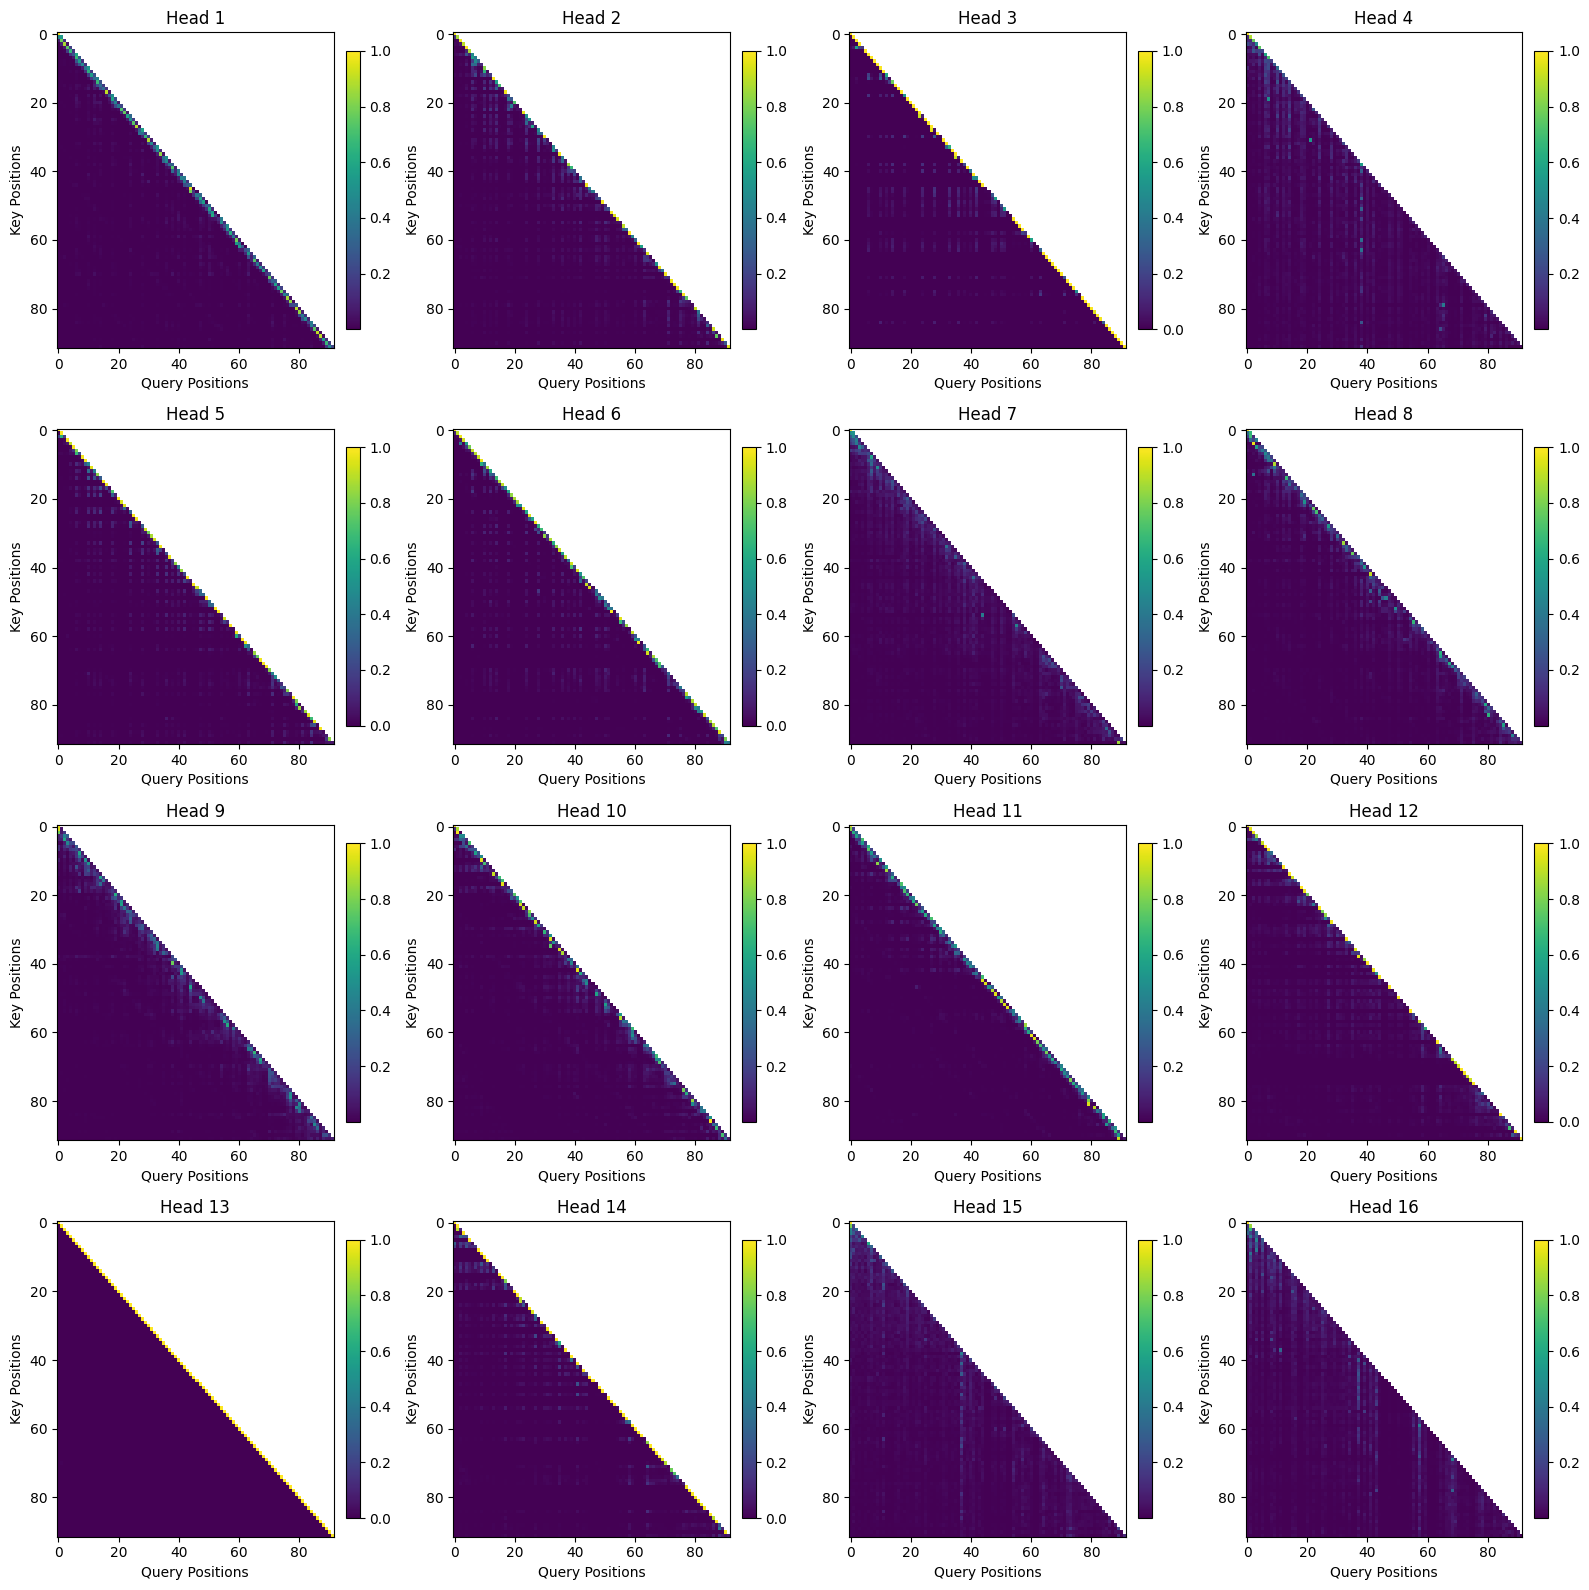

tensor(92, device='cuda:0')


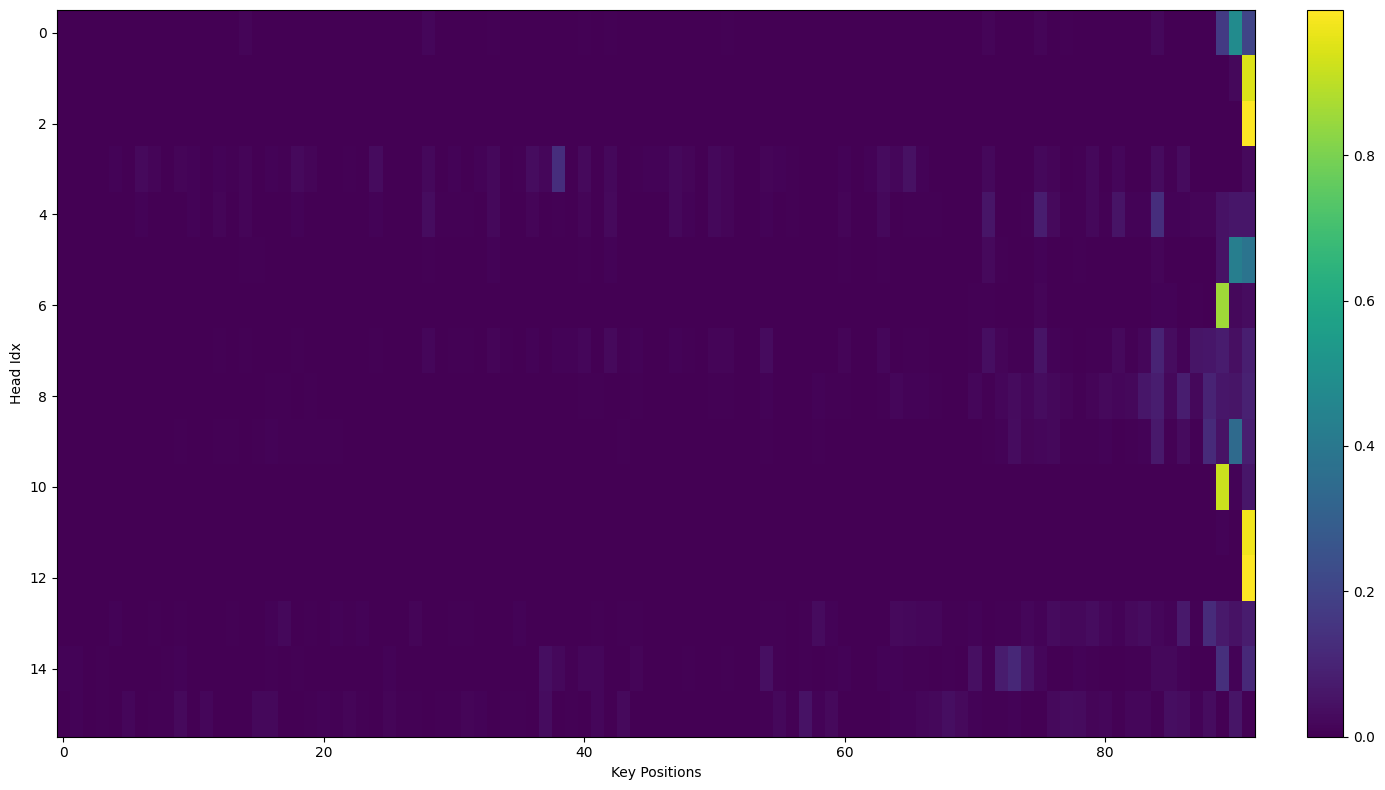

In [51]:

# Visualize the random attention patterns
for idx, b_idx in enumerate(this_batch_idxs.tolist()):
    timesteps = this_timesteps[idx]
    offset = offsets[b_idx]
    visualize_attention_patterns(
        attn_patterns[
            b_idx, :, offset : offset + timesteps, offset : offset + timesteps
        ]
    )
    print(timesteps)
    visualize_attention_patterns_at_timestep(
        attn_patterns[b_idx, :, offset : offset + timesteps, offset:offset+timesteps],
    )